In [1]:
# NOTE: probleme with librosea -> had to remove broadbeck.py

In [1]:
# pip install webdavclient3
# downloader: chmod
# librosa problem

In [1]:
from platform import python_version

assert python_version() == '3.8.0'

In [2]:
import bm
from bm.studies.pallier2023 import *
import mne
import spacy
import pandas as pd
mne.set_log_level(False)

/data/home/jeanremi/anaconda3/envs/py38/lib/python3.8/site-packages/torchaudio/_internal/module_utils.py:99: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")


In [3]:
# Pallier2023Recording.download()

In [4]:
CHAPTERS = {
    1: "1-3",
    2: "4-6",
    3: "7-9",
    4: "10-12",
    5: "13-14",
    6: "15-19",
    7: "20-22",
    8: "23-25",
    9: "26-27",
}

In [72]:
def get_syntax(file):
    with open(file, 'r') as f:
        txt = f.readlines()
    
    # parse syntactic trees
    out = []
    for sequence_id, sent in enumerate(txt):
        splits = sent.split('=')

        for prev, token in zip(splits, splits[1:]):
            out.append(dict(
                pos=prev.split('(')[-1].split()[0],
                word_id=int(prev.split()[-1]),
                word=token.split(')')[0],
                n_closing=token.count(')'),
                sequence_id=sequence_id,
                is_last_word=False,
                
            ))
        out[-1]['is_last_word'] = True
    
            
    synt = pd.DataFrame(out)
    
    # add deal with apostrophe    
    out = []
    for sent, d in synt.groupby('sequence_id'):
        for  token in d.itertuples():
            for tok in token.word.split("'"):
                out.append(dict(word=tok, n_closing=1, is_last_word=False, pos='XXX'))
            out[-1]['n_closing'] = token.n_closing
            out[-1]['is_last_word'] = token.is_last_word
            out[-1]['pos'] = token.pos
    return pd.DataFrame(out)


def add_syntax(rec):
    # get basic annotations
    meta = rec._load_events().copy().reset_index(drop=True)
    
    # get syntactic annotations
    syntax_file = StudyPaths().download / 'stimuli' / 'syntax' / f'ch{CHAPTERS[rec.run]}.syntax.txt'
    synt = get_syntax(syntax_file)

    # align
    meta_tokens = meta.word.fillna('XXXX').apply(format_text).values
    synt_tokens = synt.word.apply(format_text).values

    i, j = utils.match_list(meta_tokens, synt_tokens)
    assert (len(i) / len(meta_tokens)) > .9

    for key, default_value in dict(n_closing=1, is_last_word=False, pos='XXX').items():
        meta[key] = default_value
        meta.loc[i, key] = synt.iloc[j][key].values
    
    content_pos = ('NC', 'ADJ', 'ADV', 'VINF', 'VS', 'VPP', 'V')
    meta['content_word'] = meta.pos.apply(lambda pos: pos in content_pos if isinstance(pos, str) else False)
    return meta

In [104]:
def analysis(rec):
    # load MEG data
    raw = rec.raw()
    raw.load_data()
    raw.filter(.5, 20., n_jobs=-1);

    # get metadata
    meta = add_syntax(rec)

    # epoch
    def mne_events(meta):
        events = np.ones((len(meta), 3), dtype=int)
        events[:, 0] = meta.start*raw.info['sfreq']
        return dict(events=events, metadata=meta.reset_index())

    epochs = mne.Epochs(raw, **mne_events(meta), decim=20, tmin=-.2, tmax=1.5, preload=True)
    epochs = epochs['kind=="word"']
    
    scores = dict()
    scores['n_closing'] = decod(epochs, 'n_closing')
    scores['n_closing_notlast'] = decod(epochs['content_word and not is_last_word'], 'n_closing')
    scores['n_closing_noun_notlast'] = decod(epochs['pos=="NC" and not is_last_word'], 'n_closing')
    return scores

In [69]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from wordfreq import zipf_frequency
import matplotlib.pyplot as plt

def decod(epochs, target):
    model = make_pipeline(StandardScaler(), RidgeCV())
    cv = KFold(n_splits=5)

    y = epochs.metadata[target].values
    r = np.zeros(len(epochs.times))
    for t in trange(len(epochs.times)):
        X = epochs.get_data()[:, :, t]
        for train, test in cv.split(X, y):
            model.fit(X[train], y[train])
            y_pred = model.predict(X[test])
            r[t] += pearsonr(y_pred, y[test])[0]
    r /= cv.n_splits
    return r

In [70]:
for rec_id, rec in enumerate(Pallier2023Recording.iter()):
    if rec_id == 4:
        break

In [103]:
# score = analysis(rec)

In [87]:
# import submitit

# executor = submitit.LocalExecutor(folder='.submitit')
# executor.update_parameters(timeout_min=10)
# job = executor.submit(analysis, rec)
# r = job.result()

In [105]:
import submitit

executor = submitit.AutoExecutor(folder='.submitit')

executor.update_parameters(
    timeout_min=10,
    #mem_gb=64,
    slurm_cpus_per_task=10,
)

try:
    for job in jobs:
        job.cancel()
except:
    pass
recs = list(Pallier2023Recording.iter())[:150]
jobs = executor.map_array(analysis, recs)

In [117]:
jobs

[SlurmJob<job_id=1156_0, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_1, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_2, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_3, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_4, task_id=0, state="RUNNING">,
 SlurmJob<job_id=1156_5, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_6, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_7, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_8, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_9, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_10, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_11, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_12, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_13, task_id=0, state="RUNNING">,
 SlurmJob<job_id=1156_14, task_id=0, state="FAILED">,
 SlurmJob<job_id=1156_15, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_16, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=1156_17, task_id=0, state="COMP

In [126]:
results = []
for job in jobs:
    if job.state == 'COMPLETED':
        results.append(job.results()[0])

In [127]:
len(results)

33

In [128]:
results = pd.DataFrame(results)

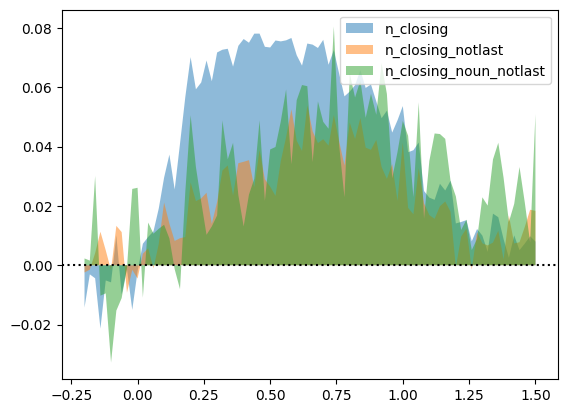

In [129]:
times = np.linspace(-.2, 1.5, 86)
for key in results.keys():
    plt.fill_between(times, np.mean(results[key].values, 0), alpha=.5, label=key)
plt.axhline(0, color='k', ls=':')
plt.legend()

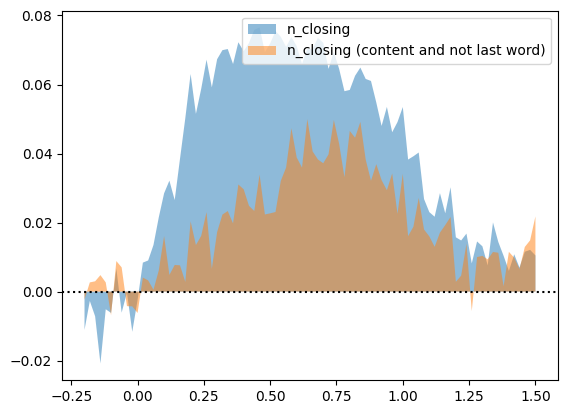

In [97]:
times = np.linspace(-.2, 1.5, 86)
plt.fill_between(times, np.mean(results['n_closing'].values, 0), alpha=.5, label='n_closing')
plt.fill_between(times, np.mean(results['n_closing_notlast'].values, 0), alpha=.5, label='n_closing (content and not last word)')
plt.axhline(0, color='k', ls=':')
plt.legend()

In [124]:
R = np.squeeze(R)

In [126]:
len(R)

285

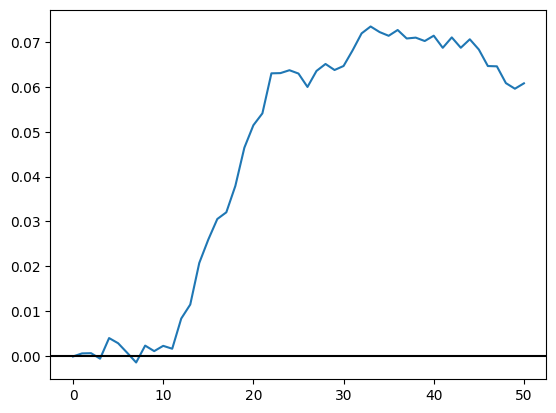

In [125]:
plt.plot(np.mean(R, 0))
plt.axhline(0, color='k')

In [71]:
r = analysis(rec)

/tmp/ipykernel_85189/2989881599.py:16: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(meta), decim=20, tmin=-.2, tmax=.8, preload=True)


  0%|          | 0/51 [00:00<?, ?it/s]

In [35]:
for rec in Pallier2023Recording.iter():
    break

/data/home/jeanremi/projects/brainmagick/bm/studies/pallier2023.py:213: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = read_raw_bids(bids_path)  # FIXME this is NOT a lazy read
/data/home/jeanremi/projects/brainmagick/bm/studies/pallier2023.py:213: RuntimeWarning: The unit for channel(s) MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306 has changed from V to NA.
  raw = read_raw_bids(bids_path)  # FIXME this is NOT a lazy read


# Legacy

In [7]:
def parse(sent):
    'identifies the number of closing nodes'

    def is_closed(node, position):
        """JR quick code to know whether is a word is closed given a word position"""
        if node.i > position:
            return False
        for child in node.children:
            if child.i > position:
                return False
            if not is_closed(child, position):
                return False
        return True

    closeds = []
    for current in range(1, len(sent)+1):
        closed = 0
        for position, word in enumerate(sent): # [:current]
            closed += is_closed(word, current)
        closeds.append(closed)

    closing = np.r_[np.diff(closeds), closeds[-1]]
    return closing


class Enrich():
    """Enrich word dataframes (e.g. mne.Epochs.metadata) with syntactic information"""
    def __init__(self,):
        model = 'fr_core_news_sm'
        if not spacy.util.is_package(model):
            spacy.cli.download(model)
    
        self.nlp = spacy.load(model)

    def __call__(self, meta, txt_file):

        # read text file
        with open(txt_file, 'r') as f:
            txt = f.read().replace('\n', '')

        # parse text file
        doc = self.nlp(txt)

        # add parse information to metadata
        parse_annots = []
        for sent_id, sent in enumerate(doc.sents):
            # HERE ADD ERIC DE LA CLERGERIE parser instead
            closings = parse(sent)
            assert len(closings) == len(sent)
            for word, closing in zip(sent, closings):
                parse_annots.append(dict(
                    word_index=word.i - sent[0].i,
                    sequence_id=sent_id,
                    sequence_uid=str(sent),
                    closing=closing,
                    match_token=word.text,
                ))
        
        # align text file and meg metadata
        def format_text(text):
            for char in ('jlsmtncd'):
                text = text.replace(f"{char}'", char)
            text = text.replace('œ', 'oe')
            return text.lower()

        meg_words = meta.word.fillna('######').values
        text_words = [format_text(w.text) for w in doc]
        
        i, j = utils.match_list(meg_words, text_words)
        
        # deal with missed tokens (e.g. wrong spelling, punctuation)
        assert len(parse_annots) == len(text_words)
        parse_annots = pd.DataFrame(parse_annots)
        parse_annots.closing = parse_annots.closing.fillna(0)
        parse_annots['closing_'] = 0
        parse_annots['missed_closing'] = 0
        missing = np.setdiff1d(range(len(parse_annots)), j)
        for missed in missing:
            current_closing = parse_annots.iloc[missed].closing
            prev_word = parse_annots.iloc[[missed-1]].index
            if prev_word[0] >=0:
                parse_annots.loc[prev_word, 'missed_closing'] = current_closing
        parse_annots.closing_ = parse_annots.closing + parse_annots.missed_closing
        
        # Add new columns to original mne.Epochs.metadata
        # fill columns
        columns = ('word_index', 'sequence_id', 'sequence_uid', 'closing_', 'match_token')
        for column in columns:
            meta[column] = None
            meta.loc[meta.iloc[i].index, column] = parse_annots[column].iloc[j].values
        return meta

In [26]:
from termcolor import colored

for a, word in enumerate(meta_tokens):
    if a in i:
        print(colored(word, 'black'), end=' ')
    else:
        print(colored(word, 'red'), end=' ')

xxxx lorsque j avais six ans j ai vu une fois une magnifique image dans un livre sur la foret vierge qui s appelait histoires vecues ca representait un serpent boa qui avalait un fauve voila la copie dessin on disait dans le livre les serpents boas avalent leur proie tout entiere sans la macher ensuite ils ne peuvent plus bouger et ils dorment pendant les six mois de leur j ai alors beaucoup reflechi sur les aventures de la jungle et a mon tour j ai reussi avec un crayon de couleur a tracer mon premier dessin mon dessin numero 1 il etait comme ca j ai montre mon chef d oeuvre grandes personnes et je leur ai demande si mon dessin leur faisait peur elles m ont repondu pourquoi un chapeau ferait il peur mon dessin ne representait pas un chapeau il representait un serpent boa qui digerait un elephant j ai alors dessine l interieur serpent boa afin que les grandes personnes puissent comprendre elles ont toujours besoin d explications mon dessin numero 2 etait comme ca les grandes personnes 